# Artifact 3: Improvement 2
### Monte Carlo Simulation 1: Investigating PR Build Minutes per Commit


### Part 1: Setup, Variable and Function Definitions, Importing Data

In [ ]:
import sys
import logging
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm
from google.cloud import bigquery
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats

client = bigquery.Client()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

We begin by defining the necessary batching function to simulate the merge queue

In [ ]:
def batch_commits_for_commit_build_times(
    commits: pd.DataFrame,
    workflow_runs: pd.DataFrame,
    batch_max_wait_time: int,
    observations: List,
):
    """
    Given a DataFrame of commits, batch them into groups based on the time between commits
    """
    current_batch_workflows = defaultdict(list)
    current_batch_end_time = commits.iloc[0]["date"] + pd.Timedelta(
        minutes=batch_max_wait_time
    )
    curr_commit_batch = [commits.iloc[0]]
    curr_batch_build_time = 0

    for i in range(1, len(commits)):
        curr_commit = commits.iloc[i]

        if curr_commit["date"] > current_batch_end_time:
            for _, build_times in current_batch_workflows.items():
                curr_batch_build_time += np.mean(
                    build_times
                )  # Take the average of all builds for a certain workflow across the batch of commits

            current_batch_end_time = curr_commit["date"] + pd.Timedelta(
                minutes=batch_max_wait_time
            )

            for c in curr_commit_batch:
                observations.append({"commit": c["sha"], "build_minutes": curr_batch_build_time / len(curr_commit_batch), "delay": batch_max_wait_time})

            current_batch_workflows = defaultdict(list)
            curr_commit_batch = []
            curr_batch_build_time = 0

        curr_commit_batch.append(curr_commit)
        workflows_for_commit = workflow_runs.loc[
            workflow_runs["head_sha"] == curr_commit["sha"]
        ]
        for _, workflow in workflows_for_commit.iterrows():
            current_batch_workflows[workflow["workflow_id"]].append(
                workflow["build_minutes"]
            )

    # Process the last batch
    for _, build_times in current_batch_workflows.items():
        curr_batch_build_time += np.mean(
            build_times
        )  # Take the average of all builds for a certain workflow across the batch of commits

    for c in curr_commit_batch:
        observations.append({"commit": c["sha"], "build_minutes": curr_batch_build_time / len(curr_commit_batch), "delay": batch_max_wait_time})

We define a process_control function to produce a control dataset representative of no PR merge queue existing and no batching, from the commits we have mined

In [ ]:
def process_control(commits_df: pd.DataFrame, workflow_runs: pd.DataFrame):
    control_data = {commits_df["sha"]: 0 for _, commits_df in commits_df.iterrows()}
    for _, workflow in workflow_runs.iterrows():
        control_data[workflow["head_sha"]] += workflow["build_minutes"]
    control_df = pd.DataFrame(list(control_data.items()), columns=["commit", "build_minutes"])
    control_df["delay"] = 0
    return control_df

We define a function to run our Monte Carlo Simulation, which samples and calls the Batch function.

In [ ]:
def run_monte_carlo_simulation(
    all_commits: pd.DataFrame, workflow_runs: pd.DataFrame, iterations: int = 10
):
    observations = []
    for _ in tqdm(range(iterations)):
        bootstrap_sample = all_commits.sample(
            n=1000, replace=True
        ).sort_index()  # retain original sorted order which which started at the earliest commit in range and is ascending by time

        merge_queue_batch_delay = np.random.randint(1, 61)
        batch_commits_for_commit_build_times(
            bootstrap_sample, workflow_runs, merge_queue_batch_delay, observations
        )
    return pd.DataFrame(observations)

We fetch the necessary data from BigQuery. Please note that you will need to be added to our GCP project for this to work and will need to have authenticated your local environment. Please refer to the project's README.md to perform this setup before you begin running the Python notebook.

In [ ]:
query_for_commit_shas = "SELECT sha, commit.committer.date FROM `scientific-glow-417622.beam.commits` ORDER BY commit.committer.date ASC"
query_for_workflow_runs = """
    SELECT
        workflow_run.head_sha,
        workflow_run.name,
        workflow_run.workflow_id,
        workflow_run.run_started_at,
        workflow_run.created_at,
        workflow_run.updated_at,
        TIMESTAMP_DIFF(workflow_run.updated_at, workflow_run.created_at, SECOND) / 60.0 AS build_minutes
    FROM
        `scientific-glow-417622.beam.commits` AS commits
    CROSS JOIN
        `scientific-glow-417622.beam.push_and_schedule_workflows`,
        UNNEST(workflow_runs) AS workflow_run
    WHERE
        commits.sha = workflow_run.head_sha AND workflow_run.event = 'push'
        """
logger.info("Fetching data from BigQuery...")
commits_df = client.query_and_wait(query_for_commit_shas).to_dataframe()
workflow_runs_df = client.query_and_wait(query_for_workflow_runs).to_dataframe()

### Part 2: Running the Control and Monte Carlo Simulations

In [ ]:
logger.info("Calculating control Build minutes...")
control_df = process_control(commits_df, workflow_runs_df)

In [ ]:
logger.info("Running Monte Carlo Simulation...")
observations_df = run_monte_carlo_simulation(
    commits_df, workflow_runs_df, iterations=10000
)
# Feel free to ignore this. 
# I had cached all my observations to a CSV file to avoid running the simulation again
# Above line that executes simulation needs to be commented out to use this.
# observations_df = pd.read_csv("observations.csv")

In [156]:
control_df

,commit,build_minutes,delay
0,b5794fc27b89dd8c550fdac7879e798f155520ad,225.916667,0
1,a93fa513181456f499e6d467f40da67fc42eda59,132.400000,0
2,472ed9f8d8645fea8aadace94ea561aa511b2d70,61.766667,0
3,84e6ceb2f0c9906fc1d64f630a320ea7c2126e92,64.200000,0
4,2f8eebb7fa7a439eecba604eacaf3611ae6f5fb6,189.600000,0
...,...,...,...
995,7ca1a5ddffdc777a6831d2d4c1d3b6dcd9905219,507.116667,0
996,c00e347c731c5f37a0ec383879922f34b8256111,157.050000,0
997,71a6c029ec75c54153c6466f28d50a439bdc5ff4,197.416667,0
998,cccdb4cd30ffae857849f99040c0e55b93372594,342.000000,0


In [157]:
# Citation: Data Aggregation step was assisted by ChatGPT.
# I was having trouble figuring out what parameters to pass in.
aggregated_observations_df = observations_df.groupby("commit").agg(
    build_minutes_mean=("build_minutes", 'mean'),
    delay_mean=("delay", 'mean'),
    build_minutes_2_5_percentile=("build_minutes", lambda x: np.percentile(x, 2.5)),
    build_minutes_97_5_percentile=("build_minutes", lambda x: np.percentile(x, 97.5)),
    delay_2_5_percentile=("delay", lambda x: np.percentile(x, 2.5)),
    delay_97_5_percentile=("delay", lambda x: np.percentile(x, 97.5)),
).reset_index()
aggregated_observations_df

,commit,build_minutes_mean,delay_mean,build_minutes_2_5_percentile,build_minutes_97_5_percentile,delay_2_5_percentile,delay_97_5_percentile
0,00462b13cc1eb36302013dea18b701e9e70b9058,116.683560,30.660766,26.825000,262.075000,2.0,59.0
1,00526dd3fa2a8fa9168cdb7f94c86af519f5c678,143.953399,30.586846,57.125000,228.500000,2.0,59.0
2,00a55272eaac451c3f364c4071e4af1ab56b88bd,82.017795,30.792329,21.952083,184.343056,2.0,59.0
3,00d5863551cc3e1f517b65d2f66eabb4c26fad95,45.369575,30.434034,17.620833,80.772222,2.0,59.0
4,00f07864784dc71b131244533abce4aaad48b5fa,6.697719,30.629029,0.000000,70.783333,2.0,59.0
...,...,...,...,...,...,...,...
995,fe262b630b3fd51854e667aa61a3ad0155f81634,173.084704,30.648716,33.583333,335.912500,2.0,59.0
996,fedca3ce18ea21424bd2381c75231e7399a8a6c2,140.535138,30.520445,55.541667,222.166667,2.0,59.0
997,ff03c129e07b9353a2005c76d91bdd12e4636565,100.766528,30.302849,34.856667,174.283333,2.0,59.0
998,ff272db75e685024dcae4cf84f3a979568c8ea62,244.764088,30.914352,103.840432,564.916667,2.0,59.0


### Part 3: Plotting and Statistical Testing
We now plot the control and experimental data together. Steps to reproduce plots and values are present here, detailed analysis of the experimental results is in **Artifact 2** in our report.

We begin by creating an initial box plot our two datasets against the build minutes consumed.

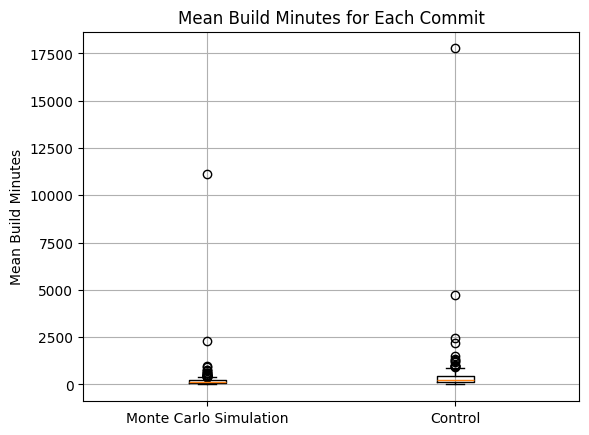

In [158]:
plt.boxplot([aggregated_observations_df["build_minutes_mean"], control_df["build_minutes"]])
plt.title("Mean Build Minutes for Each Commit")
plt.xticks([1, 2], ["Monte Carlo Simulation", "Control"])
plt.ylabel("Mean Build Minutes")
plt.grid(True)
plt.show()

This shows a clear outlier in both the control and experimental of a value above 8000 build minutes. Let's try and find it.

In [159]:
aggregated_observations_df[aggregated_observations_df["build_minutes_mean"] > 8000]

,commit,build_minutes_mean,delay_mean,build_minutes_2_5_percentile,build_minutes_97_5_percentile,delay_2_5_percentile,delay_97_5_percentile
324,539f04233c6b181ad59e952befab792768f23d5e,11144.374372,30.698714,4439.375,17757.5,2.0,59.0


It is this commit: 539f04233c6b181ad59e952befab792768f23d5e, which can be accessed at https://github.com/apache/beam/commit/539f04233c6b181ad59e952befab792768f23d5e. 

From taking a look at the diff it looks like it added a `gcp_version` to the Groovy tests which likely created a regression and caused the CI to run for a long period of time. Therefore, we remove it from our dataset to enable more clarity in investigating the rest of our data.

In [160]:
aggregated_observations_df = aggregated_observations_df[aggregated_observations_df["build_minutes_mean"] < 5000]
control_df = control_df[control_df["build_minutes"] < 5000]

We then boxplot our data again

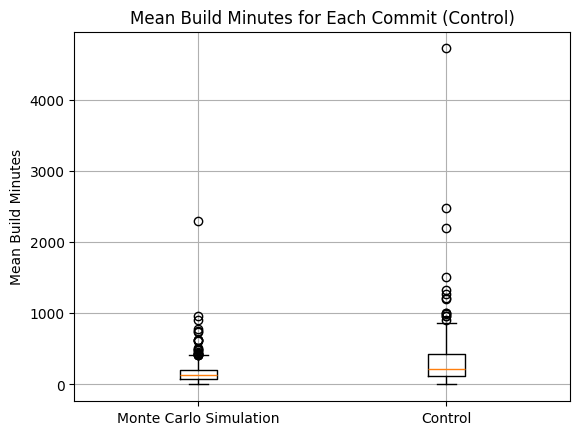

In [161]:
plt.boxplot([aggregated_observations_df["build_minutes_mean"], control_df["build_minutes"]])
plt.title("Mean Build Minutes for Each Commit (Control)")
plt.xticks([1, 2], ["Monte Carlo Simulation", "Control"])
plt.ylabel("Mean Build Minutes")
plt.grid(True)
plt.show()

Let's now focus on our experimental data and control data independantly, to better understand the shape of that data and what insights we can derive for it. Therefore, we begin by plotting the build minutes used for each commit in a violin plot. We start with the experimental and then look at the control.

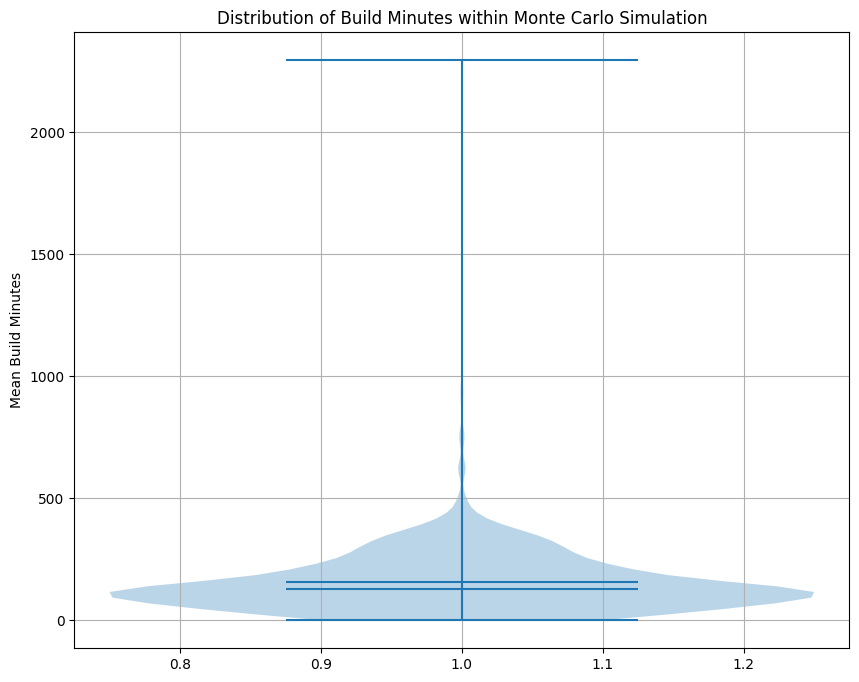

In [162]:
plt.figure(figsize=(10, 8))
plt.violinplot(aggregated_observations_df["build_minutes_mean"], showmeans=True, showmedians=True)
plt.title('Distribution of Build Minutes within Monte Carlo Simulation')
plt.ylabel('Mean Build Minutes')
plt.grid(True)
plt.show()

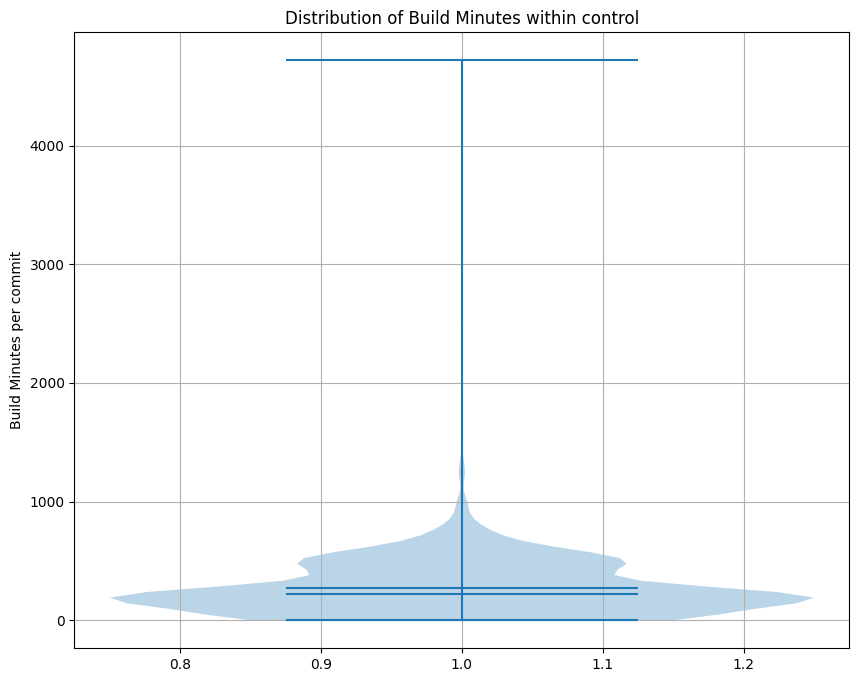

In [163]:
plt.figure(figsize=(10, 8))
plt.violinplot(control_df["build_minutes"], showmeans=True, showmedians=True)
plt.title('Distribution of Build Minutes within control')
plt.ylabel('Build Minutes per commit')
plt.grid(True)
plt.show()

Note that the axis in either plot are quite different, with the control much higher. We can overlay these violin plots on each other to see the difference. The primary thing to note here is that the mean build minutes used per commit for the experimental result which came from the Monte Carlo simulation is lower than our control, which is the build minutes without the existence of the merge queue.

Note that the control is orange while the experimental is light blue

Text(0, 0.5, 'Build Minutes per commit')

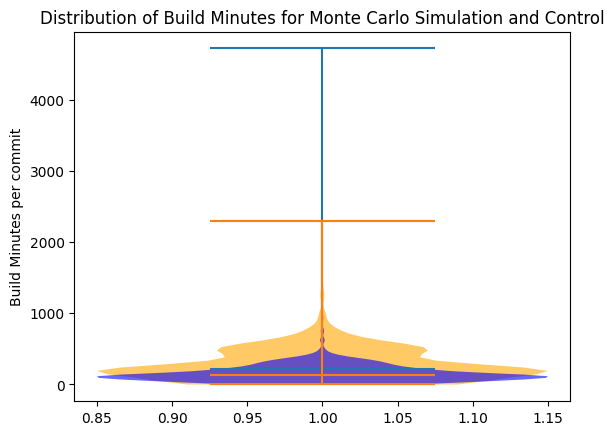

In [164]:
control_plot = plt.violinplot(control_df["build_minutes"], positions=[1], showmeans=False, showmedians=True, widths=0.3)
experimental_plot = plt.violinplot(aggregated_observations_df["build_minutes_mean"], showmeans=False, showmedians=True, widths=0.3)

for pc in control_plot['bodies']:
    pc.set_facecolor('orange')
    pc.set_alpha(0.6)

for pc in experimental_plot['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha(0.6)

plt.title('Distribution of Build Minutes for Monte Carlo Simulation and Control')
plt.ylabel('Build Minutes per commit')


### Part 4: Statistical Tests

We now do statistical tests. Since the data is paired (build minutes for a commit relate to build minutes for experimental), we need to do a paired type of test, but the type of test depends on the distribution of the build minutes. We join the dataframes together by their commit and then example, and first plot the distribution of both columns in a histogram to visually determine if it is normally distributed.

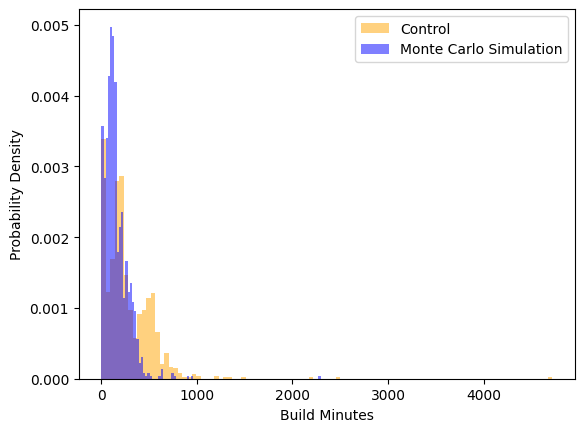

In [165]:
merged_df = aggregated_observations_df.merge(control_df, on="commit", how="inner")

merge_queue_build_minutes = merged_df["build_minutes_mean"]
control_build_minutes = merged_df["build_minutes"]

plt.hist(merged_df["build_minutes"], bins=100, alpha=0.5, label='Control', color="orange", density=True)
plt.hist(merged_df["build_minutes_mean"], bins=100, alpha=0.5, label='Monte Carlo Simulation', color="blue", density=True)
plt.xlabel("Build Minutes")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

Clearly, the data is not normally distributed. Hence, we pick a not parametric paired test, the Wilcoxon test. To determine why we used this test, we reference this page: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/mann-whitney-u-test#:~:text=The%20Mann%E2%80%93Whitney%20test%20also,test%20should%20be%20used%20instead.

In [166]:
merged_df = aggregated_observations_df.merge(control_df, on="commit", how="inner")

merge_queue_build_minutes = merged_df["build_minutes_mean"]
control_build_minutes = merged_df["build_minutes"]

# We just want to know if the merge queue build minutes are less than the control build minutes
statistic, p_value = stats.wilcoxon(merge_queue_build_minutes, control_build_minutes, alternative='less')
statistic, p_value

(26637.0, 2.667186006787401e-124)

This gives us an incredibly small p-value of $2.667 \times 10^{-124}$ (note that this could be slightly different on your run due to randomization but should be very close). We discuss how this relates to our hypotheses in our the Experimental Results section.

However, note that this p-value doesn't tell the whole story, because it is only comparing the control against the means and doesn't account for variance in the data

In [167]:
merged_df["is_control_outside"] = merged_df.apply(lambda row: row["build_minutes"] > row["build_minutes_97_5_percentile"], axis=1)

commits_above = merged_df["is_control_outside"].sum()
commits_total = len(merged_df)

print(commits_above, commits_total)

p_value = stats.binomtest(commits_above, commits_total, p=0.05, alternative='greater')
p_value

50 999


BinomTestResult(k=50, n=999, alternative='greater', statistic=0.05005005005005005, pvalue=0.5173695437269736)